<a href="https://colab.research.google.com/github/derzhavin3016/CompMath/blob/master/Lab10/Lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя лабораторная работа №10 по вычислительной математике

Державин Андрей, Б01-909

## Задача ??

Реализация схемы бегущего счёта (минимум 2 порядка апроксимации) для уравнения
$$
\left\lbrace
\begin{matrix}
\dfrac{\partial u}{\partial t} + c(x, t) \dfrac{\partial u}{\partial x} &=& f(x, t),& \: 0 \leq x \leq X, \: 0 \leq t \leq T \\
u(0, t) &=& \psi(t),&  0 \leq t \leq T \\
u(x, 0) &=& \varphi(x),& 0 \leq x \leq X
\end{matrix}
\right.
$$


### Описание метода

Введём сетку
$$
\left\lbrace 
x_n = n \cdot h, n = \overline{0\dots N}, N = X/h; \:\:\:
t_j = j \cdot \tau, n = \overline{0\dots J}, J = T/\tau;
\right\rbrace
$$

Будем использовать схему прямоугольник
$$
\dfrac{1}{2} \left(
\frac{u^{j}_{n-1} - u^{j-1}_{n-1}}{\tau} + 
\frac{u^{j}_{n} - u^{j-1}_{n}}{\tau}
\right) + 
\dfrac{
  c(x_n - 0.5 h, t_j - 0.5 \tau)
}{2} \left(
\frac{u^{j}_{n} - u^{j}_{n-1}}{h} + 
\frac{u^{j-1}_{n} - u^{j-1}_{n-1}}{h}
\right) = f(x_n - 0.5 h, t_j - 0.5 \tau)
$$
Выразим отсюда $u^{j}_{n}$:
$$
u^{j}_{n} = -\frac{ 
\dfrac{u^{j}_{n-1} - u^{j-1}_{n-1} - u^{j-1}_{n}}{2\tau} + 
\dfrac{
  c(x_n - 0.5 h, t_j - 0.5 \tau)
  \left(
    u^{j-1}_{n} - u^{j-1}_{n-1} - u^{j}_{n-1}
  \right)
}{2h} - f(x_n - 0.5 h, t_j - 0.5 \tau)}
{
  \dfrac{1}{2\tau} + 
\dfrac{
  c(x_n -  0.5 h, t_j - 0.5 \tau)
}{2h}
}
$$

Краевые и начальные условия запишутся в виде:
$$
\left\lbrace
\begin{matrix}
u^j_0 = \psi(j \cdot \tau) \\
u^0_n = \varphi(n \cdot h) \\
\end{matrix}
\right.
$$

### Аналитическое решение

Получим аналитическое решение этой задачи. Решим её методом характеристик. Уравнение характеристик имеет вид:
$$
dt = \dfrac{dx}{2}
$$
Интегрируем его и получаем семейство характеристик
$$
2t - x = C
$$
Введём параметр $\tau$:
$$
\left\lbrace
\begin{matrix}
x = 2\tau - C \\
t = \tau
\end{matrix}
\right.
$$
Задача в новых переменных принимает вид:
$$
\left\lbrace
\begin{matrix}
\dfrac{dU}{d\tau} &=& 3\tau - C,& \\
\left. U \right|_{\tau=0} &=& \cos{\pi C},& C \leq 0\\
\left. U \right|_{\tau=\frac{C}{2}} &=& e^{-C/2},& C > 0\\
\end{matrix}
\right.
$$
Общее решение уравнения:
$$
U = \dfrac{3}{2}\tau^2 - C\tau + A
$$

Применим граничные условия:
$$
\left. U \right|_{\tau=0} = \cos{\pi C} = A, \: C \leq 0
$$
$$
\left. U \right|_{\tau=\frac{C}{2}} = e^{-C/2} = \dfrac{3C^2}{8} - \dfrac{C^2}{2} + A \Rightarrow A = e^{-C/2} + \dfrac{C^2}{8}, \:\: C > 0
$$
Таким образом,
$$
u(x, t) = 
\left\lbrace
\begin{matrix}
xt - \dfrac{t^2}{2} + \cos{\left(\pi \left(2t - x \right)\right)}, & 2t \leq x\\
xt - \dfrac{t^2}{2} + \dfrac{\left(2t-x \right)^2}{8} + e^{-t + x / 2}, & 2t > x\\
\end{matrix}
\right.
$$

### Реализация

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

In [9]:
T = 1
X = 1
h = 1e-3
tau = 1e-3
N = int(X / h)
J = int(T / tau)
u = np.zeros((J, N))

def c(x, t):
  return 2

def f(x, t):
  return x + t

def phi(x):
  return np.cos(np.pi * x)

def psi(t):
  return np.exp(-t)

def get_next_u(j, n):
  by_t = u[j][n - 1] - u[j - 1][n - 1] - u[j - 1][n]
  by_t /= 2 * tau

  by_x = u[j - 1][n] - u[j - 1][n - 1] - u[j][n - 1]
  c_part = c((n - 0.5) * h, (j - 0.5) * tau) 
  by_x *= c_part / (2 * h)

  f_part = f((n - 0.5) * h, (j - 0.5) * tau)

  num = by_t + by_x - f_part

  den = 1 / (2 * tau) + c_part / (2 * h)

  return -num / den

def solve():
  for i in range(u.shape[0]):
    u[i][0] = psi(i * tau)

  for i in range(u.shape[1]):
    u[0][i] = phi(i * h)

  for j in range(1, u.shape[0]):
    for n in range(1, u.shape[1]):
      u[j][n] = get_next_u(j, n)


solve()

Сравнение с аналитиическим решением

In [11]:
u_an = np.zeros((u.shape[0], u.shape[1]))
for i in range(u.shape[0]):
  for j in range(u.shape[1]):
    t = i * tau
    x = j * h
    if 2 * t > x:
      u_an[i][j] = x * t  - t ** 2 / 2 + (2 * t - x) ** 2 / 8 + np.exp(-(t - x / 2))
    else:
      u_an[i][j] = x * t  - t ** 2 / 2 + np.cos(np.pi * (2 * t - x))

np.mean(np.abs(u - u_an))

1.7950337228189264e-05

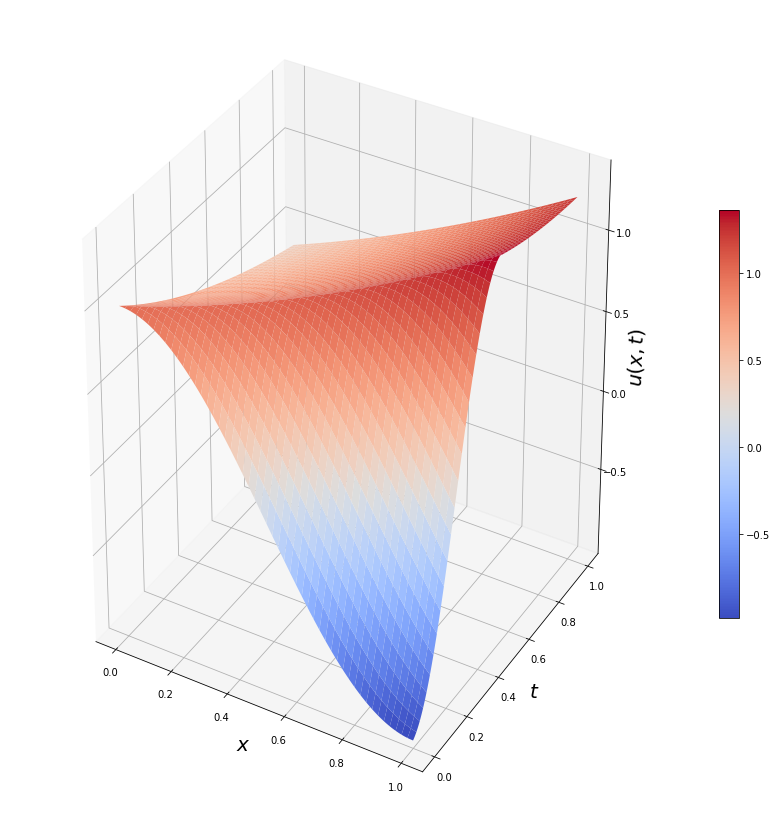

In [12]:
x = np.array([i * h for i in range(u.shape[1])])
t = np.array([i * tau for i in range(u.shape[0])])

x, y = np.meshgrid(x, t)
fig = plt.figure(figsize=(15, 15))
graph = plt.axes(projection='3d')
surf = graph.plot_surface(x, y, u, cmap="coolwarm")
graph.set_xlabel("$x$", fontsize=20)
graph.set_ylabel("$t$", fontsize=20)
graph.set_zlabel("$u(x, t)$", fontsize=20)
fig.colorbar(surf, shrink=0.5)
plt.grid()

In [ ]:
!sudo apt install ffmpeg
!sudo apt install imagemagick

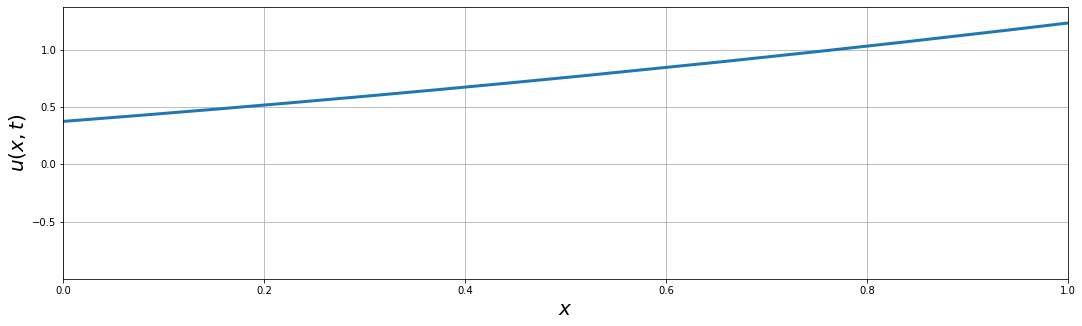

In [ ]:
fig = plt.figure(figsize=(18, 5))
ax = plt.axes(xlim=(0, X), ylim=[np.min(u), np.max(u)])
line, = ax.plot([], [], lw=3)
ax.grid()
ax.set_ylabel("$u(x, t)$", fontsize=20)
ax.set_xlabel("$x$", fontsize=20)

frames_amount = 60

def init():
  line.set_data([], [])
  return line,

def animate(i):
  x = np.array([i * h for i in range(u.shape[1])])
  line.set_data(x, u[int(i / frames_amount * (u.shape[0] - 1))])
  return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=frames_amount, interval=60, blit=True)
anim.save('solution.gif', writer='imagemagick')

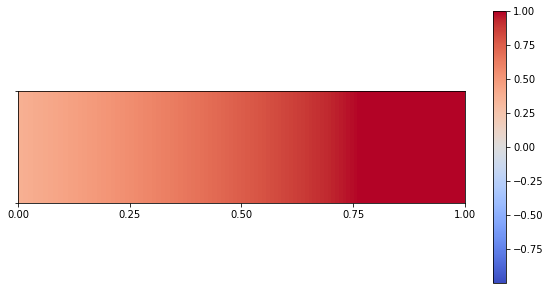

In [ ]:
fr_am = 50
fg = plt.figure(figsize=(10, 5))
ax = plt.axes()
heat = np.array([u[0] for i in range(int(u.shape[0] / 2))])
im = plt.imshow(heat, cmap='coolwarm', extent=[0, X, 0, X / 4])
plt.yticks(np.linspace(0, X / 4, 2), "")
plt.xticks(np.linspace(0, X, 5))
plt.colorbar()

def animation(t):
  idx = int(t / fr_am * (u.shape[0] - 1)) 
  heat = np.array([u[idx] for i in range(int(u.shape[0] / 2))])
  im.set_array(heat)
  return [im]

anim = FuncAnimation(fg, animation, frames=fr_am, interval=60, blit=True)
anim.save('heatmap.gif', writer='imagemagick')